# Store kitti sequence

Create a sequence

In [1]:
# when you change a setting you have to restart the kernel (settings are only loaded once)
import os
#os.environ['STEREO_CONFIDENCE'] = '1.6'
os.environ['SEQUENCE_CONFIDENCE'] = '1.6'
#os.environ['PATCH_SIZE'] = '17'
FRAMECOUNT = 1101

import sys
sys.path.append('..')
from src.kitti import *
%matplotlib inline
import numpy as np
import glob
import urbg2o
import cv2


IMAGE_SIZE = 400

def load(file):
    keyframeids, frameids, poses = load_keyframes(file)
    return keyframeids, frameids, poses.reshape(poses.shape[0], 4, 4)

def load_csv(file):
    poses = np.genfromtxt(file, delimiter= " ")
    poses = np.hstack([poses, np.repeat(np.array([[0,0,0,1.0]]), len(poses), axis=0) ])
    return poses.reshape(poses.shape[0], 4, 4)

def transform(poses):
    points = np.repeat(np.array([[0,0,0,1.0]]), len(poses), axis=0) 
    for i in range(1, len(poses)):
        points[:i] = np.dot(points[:i], poses[i].T)
    return points
        
def transform2(poses):
    points = poses[:,:,3]
    return points
    
def plot_trajectory(points):
    # remove y coordinate (we only use x and z to plot a view from above)
    points = points[:, [0,2,3]]
    # compute min and max
    pmin = points.min(axis=0)
    pmax = points.max(axis=0)
    maxxy = max(pmax[0] - pmin[0], pmax[1] - pmin[1])

    t = np.eye(3, dtype=np.float64)
    t[0,0] = IMAGE_SIZE / maxxy
    t[1,1] = -IMAGE_SIZE / maxxy
    t[0,2] = -pmin[0] * IMAGE_SIZE / maxxy
    t[1,2] = IMAGE_SIZE / maxxy + pmin[1] / maxxy + 100

    return np.dot(points, t.T)
    

def plot_trajectory2(points):
    # remove y coordinate (we only use x and z to plot a view from above)
    points = points[:, [0,2,3]]
    # compute min and max
    pmin = points.min(axis=0)
    pmax = points.max(axis=0)
    maxxy = max(pmax[0] - pmin[0], pmax[1] - pmin[1]) * 1.01

    t = np.eye(3, dtype=np.float64)
    t[0,0] = IMAGE_SIZE / maxxy
    t[1,1] = -IMAGE_SIZE / maxxy
    t[0,2] = -pmin[0] * IMAGE_SIZE / maxxy
    t[1,2] = IMAGE_SIZE / maxxy + pmin[1] / maxxy + 100
    return np.dot(points, t.T)
    
def plot_trajectory3(points):
    coords = []
    minx = min([p[0] for p in points])
    maxx = max([p[0] for p in points])
    miny = min([p[2] for p in points])
    maxy = max([p[2] for p in points])
    maxxy = max(maxx - minx, maxy - miny)* 1.01

    for p in points:
        #print(p)
        x = IMAGE_SIZE * (p[0] - minx) / (maxxy)
        z = IMAGE_SIZE - IMAGE_SIZE * (p[2] - miny) / (maxxy)
        coords.append([x, z])
    return coords

def new_image():
    img = np.zeros((IMAGE_SIZE, IMAGE_SIZE, 3), np.uint8)
    img[:] = 255 #or img.fill(255)
    return img

def draw(coords, img, color = (0,0,0)):
    # Draw a black line with thickness of 2 px
    for i in range(1,len(coords)):
        cv2.line(img, (int(coords[i - 1][0]), int(coords[i - 1][1])), (int(coords[i][0]), int(coords[i][1])), color, 2)
    return img

Read the first 10 frames from KITTI sequence 00.

In [2]:
%%time
SEQUENCE=7
LEFTDIR = '/data/urbinn/datasets/kitti/sequences/%02d/image_0'%SEQUENCE
RIGHTDIR = '/data/urbinn/datasets/kitti/sequences/%02d/image_1'%SEQUENCE

frame = []
for filename in sorted(glob.glob(LEFTDIR + '/*')):
    left_frame = Frame(filename, RIGHTDIR)
    frame.append(left_frame)

CPU times: user 4.71 ms, sys: 1.39 ms, total: 6.1 ms
Wall time: 5.21 ms


Add the frames to a sequence. By adjusting the [:] you can use only a slice of the list of frames.

In [3]:
seq = Sequence()
for f in ProgressBar()(frame[:50]):
    seq.add_frame(f, run_ba=False)

 30% (15 of 50) |#######                  | Elapsed Time: 0:00:04 ETA:  0:00:09

invalid speed keyframe 0 frame 15 speed 5.327399052273023
 [[ 0.96429017 -0.02046098  0.26405646  0.43692592]
 [ 0.01854521  0.99978052  0.00974613  0.17454191]
 [-0.26419792 -0.00450112  0.96445798  3.38241711]
 [ 0.          0.          0.          1.        ]]


 50% (25 of 50) |############             | Elapsed Time: 0:00:13 ETA:  0:00:18

invalid speed keyframe 14 frame 25 speed 0.6755461904974798
 [[ 0.90112818  0.02001582  0.43309048 -0.16954157]
 [-0.02426002  0.99969654  0.00427542 -0.30710328]
 [-0.43287348 -0.01435948  0.90134031 -1.61791738]
 [ 0.          0.          0.          1.        ]]


 66% (33 of 50) |################         | Elapsed Time: 0:00:26 ETA:  0:00:25

invalid speed keyframe 30 frame 33 speed 1.3670261139332793
 [[ 0.98390095 -0.00979807  0.17844583 -0.60921361]
 [ 0.01014621  0.99994799 -0.00103848 -0.02671571]
 [-0.17842637  0.00283231  0.98394919  0.72618835]
 [ 0.          0.          0.          1.        ]]


 82% (41 of 50) |####################     | Elapsed Time: 0:00:31 ETA:  0:00:05

invalid speed keyframe 36 frame 41 speed 0.14740374466830786
 [[ 0.97777708 -0.00903891  0.20945233  0.03169646]
 [ 0.00828333  0.99995564  0.00448437  0.03315155]
 [-0.20948357 -0.00264975  0.97780858 -1.21692951]
 [ 0.          0.          0.          1.        ]]


 86% (43 of 50) |#####################    | Elapsed Time: 0:00:32 ETA:  0:00:03

invalid speed keyframe 40 frame 43 speed 0.10777959463083375
 [[  9.95589648e-01   3.89974895e-04   9.38141780e-02  -1.68504096e-01]
 [ -1.00088661e-03   9.99978601e-01   6.46496952e-03   4.99697517e-03]
 [ -9.38096493e-02  -6.53035409e-03   9.95568734e-01  -8.34921916e-01]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   1.00000000e+00]]


100% (50 of 50) |#########################| Elapsed Time: 0:00:35 Time: 0:00:35


In [4]:
%%time
SEQUENCE=7
LEFTDIR = '/data/urbinn/datasets/kitti/sequences/%02d/image_0'%SEQUENCE
RIGHTDIR = '/data/urbinn/datasets/kitti/sequences/%02d/image_1'%SEQUENCE

kframe = []
for filename in sorted(glob.glob(LEFTDIR + '/*')):
    left_frame = Frame(filename, RIGHTDIR)
    kframe.append(left_frame)

CPU times: user 5.7 ms, sys: 60 µs, total: 5.76 ms
Wall time: 4.86 ms


In [5]:
kseq = Sequence()
for f in ProgressBar()(kframe[:50]):
    kseq.add_keyframe(f, run_ba=False)

100% (50 of 50) |#########################| Elapsed Time: 0:01:34 Time: 0:01:34


Example of how to save a set of covisible keyframes, fixed keyframes, mappoints and edges to use for local bundle adjustment

In [6]:
print('Keyframes count\n', (len(seq.keyframes)), '\n')

def keyframes_to_np(keyframes):
    return np.hstack([ [ [ kf.keyframeid] for kf in keyframes ], [ [kf.frameid] for kf in keyframes ], [ kf.get_world_pose().flatten() for kf in keyframes ] ])

Keyframes count
 9 



In [7]:
#cv_keyframes = [ seq.keyframes[f] for f in range(0,12) ]
cv_keyframes = get_covisible_keyframes(seq.keyframes[-1])
mappoints = get_mappoints(cv_keyframes)
f_keyframes = get_fixed_keyframes(mappoints, cv_keyframes)[:0]

cv_keyframes_np = keyframes_to_np(cv_keyframes)
f_keyframes_np = keyframes_to_np(f_keyframes)
mappoints_np = mappoints_to_np(mappoints)
links_np = links_to_np(mappoints)


f_keyframes = np.asfortranarray(f_keyframes_np)
cv_keyframes_BA = np.asfortranarray(cv_keyframes_np)
mappoints = np.asfortranarray(mappoints_np)
links = np.array(links_np, order='f')

#cv_keyframes_BA[-1,2:] = cv_keyframes_BA[-1,2:] * 2
#print(cv_keyframes_BA[3])
results =  urbg2o.localBundleAdjustment(cv_keyframes_BA, f_keyframes, mappoints, links)

#[f.frameid for f in cv_keyframes]
cv_keyframes_np[:, [5,13]].reshape((-1,2))

array([[-1.4786598 , -5.47927559],
       [-1.96587798, -5.90001576],
       [-3.05821289, -6.51802885],
       [-4.36440444, -6.91342361],
       [-5.29858492, -7.05110912]])

In [8]:
cv_keyframes_BA[:,[5,13]]

array([[-1.4786598 , -5.47927559],
       [-1.96587798, -5.90001576],
       [-3.30906515, -6.48800863],
       [-4.47487944, -7.70161939],
       [-4.92678299, -8.21075328]])

In [9]:
#cv_keyframes = [ kseq.keyframes[f] for f in range(0,50) ]
cv_keyframes = get_covisible_keyframes(kseq.keyframes[-1])
mappoints = get_mappoints(cv_keyframes)
f_keyframes = get_fixed_keyframes(mappoints, cv_keyframes)[:0]

cv_keyframes_np = keyframes_to_np(cv_keyframes)
f_keyframes_np = keyframes_to_np(f_keyframes)
mappoints_np = mappoints_to_np(mappoints)
links_np = links_to_np(mappoints)


f_keyframes = np.asfortranarray(f_keyframes_np)
cv_keyframes_BA = np.asfortranarray(cv_keyframes_np)
mappoints = np.asfortranarray(mappoints_np)
links = np.array(links_np, order='f')

#cv_keyframes_BA[-1,2:] = cv_keyframes_BA[-1,2:] * 2
#print(cv_keyframes_BA[3])
results =  urbg2o.localBundleAdjustment(cv_keyframes_BA, f_keyframes, mappoints, links)

#[f.frameid for f in cv_keyframes]
cv_keyframes_np[:, [5,13]].reshape((-1,2))

array([[-4.09968655, -7.02047183],
       [-4.53478642, -7.13476787],
       [-4.97538021, -7.22520976],
       [-5.43469303, -7.29352598],
       [-5.91188695, -7.3463713 ],
       [-6.41059578, -7.38042733],
       [-6.92783784, -7.40082659],
       [-7.46033577, -7.40118929],
       [-8.01465884, -7.39089254],
       [-8.5768887 , -7.36802567],
       [-9.17149725, -7.34451752],
       [-9.76739199, -7.30644992]])

In [10]:
len(links) / 50

77.14

In [11]:
#links2 = [ l for l in links if l[1] == 2.0]
#[ l for l in links if int(l[0]) >= len(mappoints)]
#mid2 = [ int(m[0]) for m in mappoints ]
#[ l for l in links2 if int(l[0]) not in mid2 ]
cv_keyframes_BA[:, [5,13]].reshape((-1,2))

array([[ -4.09968655,  -7.02047183],
       [ -4.53478642,  -7.13476787],
       [ -4.88803448,  -7.2459392 ],
       [ -5.10107206,  -7.51514553],
       [ -5.30345791,  -7.80150019],
       [ -5.48078285,  -8.11881967],
       [ -5.60765969,  -8.47579191],
       [ -5.73679987,  -8.86358031],
       [ -5.87149405,  -9.30538854],
       [ -5.94949646,  -9.73011135],
       [ -5.99825548, -10.20036542],
       [ -6.03513426, -10.6888592 ]])

In [12]:

cv_keyframes = get_covisible_keyframes(seq.keyframes[-1])
#cv_keyframes = [ seq.keyframes[f] for f in range(0,50) ]

mappoints = get_mappoints(cv_keyframes)
f_keyframes = get_fixed_keyframes(mappoints, cv_keyframes)[:0]

cv_keyframes_np = keyframes_to_np(cv_keyframes)
f_keyframes_np = keyframes_to_np(f_keyframes)
mappoints_np = mappoints_to_np(mappoints)
links_np = links_to_np(mappoints)


f_keyframes = np.asfortranarray(f_keyframes_np)
cv_keyframes_BA = np.asfortranarray(cv_keyframes_np)
mappoints = np.asfortranarray(mappoints_np)
links = np.array(links_np, order='f')

outliers =  urbg2o.outliersForLocalBundleAdjustment(cv_keyframes_BA, f_keyframes, mappoints, links)

#cv_keyframes_np[:,[5,13]]

In [13]:
countsp = [0] * 50
counts = [0] * 50
for o in outliers:
    if o[2] > 6:
        counts[int(o[0])] += 1
for o in links:
    countsp[int(o[1])] += 1
for i in range(len(counts)):
    counts[i] /= countsp[i] + 0.001
counts

[0.0,
 0.0,
 0.0,
 0.0,
 0.40948099361640683,
 0.5358627178788276,
 0.6718715006692674,
 0.26666548148674896,
 0.0760229472342267,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [14]:
from sortedcontainers import SortedSet

inliers = { (int(pointid), int(frameid)) for frameid, pointid, chi2 in outliers if chi2 < 5.8 }
keptpoints = SortedSet({ l[0] for l in inliers })
keptframes = SortedSet({ l[1] for l in inliers })
#m_keptpoints = { p:i for i, p in enumerate(keptpoints) }
#m_keptframes = { p:i for i, p in enumerate(keptframes) }
cv_keyframes1 = [ f for f in cv_keyframes if f.keyframeid in keptframes]
fixed_keyframes1 = [ f for f in f_keyframes if f.keyframeid in keptframes]
mappoints1 = [ f for f in mappoints if int(f[0]) in keptpoints]
links1 = [ (l[0], l[1], l[2], l[3]) for l in links if (int(l[0]), int(l[1])) in inliers ]

In [15]:
len(mappoints), len(links)

(520, 1219)

In [16]:
len(inliers) / len(links)

0.5184577522559475

In [17]:
cv_keyframes1_np = keyframes_to_np(cv_keyframes1)
f_keyframes1_np = keyframes_to_np(fixed_keyframes1)
links1_np = np.array(links1, dtype=np.float64, order='f')

f_keyframes1 = np.asfortranarray(f_keyframes1_np)
cv_keyframes1_BA = np.asfortranarray(cv_keyframes1_np)
mappoints1 = np.asfortranarray(mappoints1)
links1 = np.array(links1_np, order='f')

results =  urbg2o.localBundleAdjustment(cv_keyframes1_BA, f_keyframes1, mappoints1, links1)



In [18]:
cv_keyframes1_BA[:,2:]

array([[  5.78322304e-01,  -1.24216917e-02,   8.15713807e-01,
         -1.47865980e+00,   1.12832454e-02,   9.99910225e-01,
          7.22707396e-03,   9.58632572e-02,  -8.15730348e-01,
          5.02432103e-03,   5.78410542e-01,  -5.47927559e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.00000000e+00],
       [  4.76672366e-01,  -1.10467812e-02,   8.79011618e-01,
         -1.96587798e+00,   1.08619604e-02,   9.99918721e-01,
          6.67600613e-03,   8.94121508e-02,  -8.79013921e-01,
          6.36552179e-03,   4.76753612e-01,  -5.90001576e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.00000000e+00],
       [  2.62910655e-01,  -3.34348252e-03,   9.64814391e-01,
         -3.30781360e+00,   1.96914535e-02,   9.99804297e-01,
         -1.90115816e-03,   1.94008277e-01,  -9.64619217e-01,
          1.94984324e-02,   2.62925040e-01,  -6.47040373e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.0000

In [19]:

cv_keyframes = { seq.keyframes[i] for i in range(0,7,2) }
mappoints = get_mappoints(cv_keyframes)
f_keyframes = { }

cv_keyframes_np = keyframes_to_np(cv_keyframes)
f_keyframes_np = keyframes_to_np(f_keyframes)
mappoints_np = mappoints_to_np(mappoints)
links_np = links_to_np(mappoints)


f_keyframes = np.asfortranarray(f_keyframes_np)
cv_keyframes_BA = np.asfortranarray(cv_keyframes_np)
mappoints = np.asfortranarray(mappoints_np)
links = np.array(links_np, order='f')

# np.set_printoptions(threshold=np.nan)

# print('mappoints count  \n', (len(mappoints[:]), '\n') )
# print('mappoints \n', (mappoints[:]), '\n')
# print('links count  \n', (len(links[:]), '\n') )
# print('links \n', (links[:]), '\n')

# print('Keyframes \n', (cv_keyframes), '\n')
# print('Keyframes numpy \n', (cv_keyframes_np[:, 2 :]), '\n')
# print('mappoints len \n', len(mappoints_np), '\n')
# print('Fixed Keyframes \n',f_keyframes[:], '\n')

# print('Keyframes before BA \n', (cv_keyframes_BA[: , 2:]), '\n')
# print(len(cv_keyframes_BA), '\n')

outliers =  urbg2o.outliersForLocalBundleAdjustment(cv_keyframes_BA, f_keyframes, mappoints, links)

# print('Keyframes after BA \n', (cv_keyframes_BA[:, 2 :]), '\n')
# print(len(cv_keyframes_BA), '\n')

In [20]:
from sortedcontainers import SortedSet

inliers = { (int(pointid), int(frameid)) for frameid, pointid, chi2 in outliers if chi2 < 10 }
keptpoints = SortedSet({ l[0] for l in inliers })
keptframes = SortedSet({ l[1] for l in inliers })
m_keptpoints = { p:i for i, p in enumerate(keptpoints) }
m_keptframes = { p:i for i, p in enumerate(keptframes) }
cv_keyframes1 = [ f for i, f in enumerate(cv_keyframes) if i in keptframes]
fixed_keyframes1 = [ f for i, f in enumerate(f_keyframes) if i + len(cv_keyframes) in keptframes]
mappoints1 = [ f for i, f in enumerate(mappoints) if i in keptpoints]
links1 = [ (m_keptpoints[l[0]], m_keptframes[l[1]], l[2], l[3]) for l in links if (int(l[0]), int(l[1])) in inliers ]

In [21]:
len(inliers) / len(links)

0.3565629228687415

In [22]:
cv_keyframes1_np = keyframes_to_np(cv_keyframes1)
f_keyframes1_np = keyframes_to_np(fixed_keyframes1)
links1_np = np.array(links1, dtype=np.float64, order='f')

f_keyframes1 = np.asfortranarray(f_keyframes1_np)
cv_keyframes1_BA = np.asfortranarray(cv_keyframes1_np)
mappoints1 = np.asfortranarray(mappoints1)
links1 = np.array(links1_np, order='f')

results =  urbg2o.localBundleAdjustment(cv_keyframes1_BA, f_keyframes1, mappoints1, links1)



In [23]:
cv_keyframes1_BA[:, 2:]

array([[ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ],
       [ 0.81284704, -0.01842977,  0.58218556, -0.6021169 ,  0.01221095,
         0.99981883,  0.01460153, -0.04100789, -0.58234919, -0.00475978,
         0.81292482, -4.15768696,  0.        ,  0.        ,  0.        ,
         1.        ]])

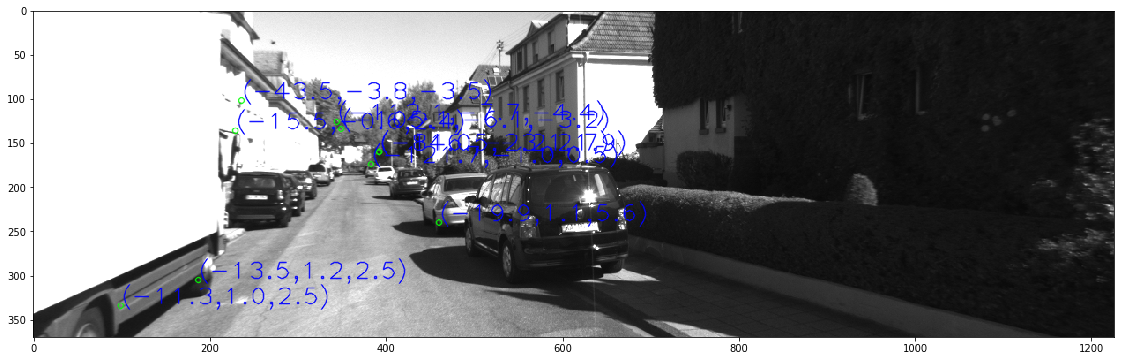

In [24]:
o = seq.keyframes[-3].get_observations()[:10]
show(draw_observations_xyz(o))